In [1]:
from pathlib import Path


result_folder = Path(
    "/vol/bitbucket/ad6013/Research/CausalStructureNeuralProcess/ml2_meta_causal_discovery/experiments/causal_classification/linear_gaussian"
)
result_file = result_folder / "results_withqlbefore.json"


In [2]:
import json


with open(result_file, "r") as f:
    results = json.load(f)

In [3]:
for model, scores in results.items():
    print(f"Model: {model}")
    for score, value in scores.items():
        print(f"  {score}: {value}")
    print()

Model: causal_qbeforel
  e_shd: [21.601999282836914, 21.36400032043457, 10.543999671936035, 14.220000267028809, 26.167999267578125, 12.947999954223633, 21.06999969482422, 15.763999938964844, 21.79199981689453, 22.827999114990234, 23.15999984741211, 10.770000457763672, 23.281999588012695, 22.440000534057617, 24.857999801635742, 15.444000244140625, 21.83799934387207, 21.052000045776367, 12.630000114440918, 12.616000175476074, 22.33799934387207, 23.20199966430664, 11.817999839782715, 14.538000106811523, 12.015999794006348, 20.02400016784668, 14.043999671936035, 11.331999778747559, 21.95599937438965, 11.847999572753906, 11.564000129699707, 23.104000091552734, 19.959999084472656, 14.411999702453613, 22.920000076293945, 21.176000595092773, 12.45199966430664, 21.68400001525879, 11.428000450134277, 21.003999710083008, 19.489999771118164, 22.695999145507812, 21.729999542236328, 25.892000198364258, 13.305999755859375, 10.923999786376953, 14.428000450134277, 10.88599967956543, 13.067999839782715,

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def create_plots(data):
    # Convert the nested dictionary to a pandas DataFrame
    df = pd.DataFrame([
        (model, 'e_shd', value)
        for model, scores in data.items()
        for value in scores['e_shd']
    ] + [
        (model, 'auc', value)
        for model, scores in data.items()
        for value in scores['auc']
    ] + [
        (model, 'log_prob', value)
        for model, scores in data.items()
        for value in scores['log_prob']
    ] + [
        (model, 'e_f1', value)
        for model, scores in data.items()
        for value in scores['e_f1'] if value != 0
    ], columns=['Model', 'Metric', 'Score'])

    # Create a separate DataFrame for test loss
    df_test_loss = pd.DataFrame([
        (model, scores['test_loss'])
        for model, scores in data.items()
    ], columns=['Model', 'Test Loss'])

    # Set up the matplotlib figure
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 24))
    fig.suptitle('Model Performance Metrics', fontsize=16)

    # Create box plot for e_shd
    sns.boxplot(x='Model', y='Score', data=df[df['Metric'] == 'e_shd'], ax=ax1)
    ax1.set_title('E_SHD Scores')
    ax1.set_xlabel('Model')
    ax1.set_ylabel('E_SHD Score')

    # Create box plot for e_f1
    sns.boxplot(x='Model', y='Score', data=df[df['Metric'] == 'e_f1'], ax=ax2)
    ax2.set_title('E_F1 Scores')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('E_F1 Score')

    sns.boxplot(x='Model', y='Score', data=df[df['Metric'] == 'auc'], ax=ax3)
    ax3.set_title('AUC Scores')
    ax3.set_xlabel('Model')
    ax3.set_ylabel('AUC Score')

    # Create box plot for e_f1
    sns.boxplot(x='Model', y='Score', data=df[df['Metric'] == 'log_prob'], ax=ax4)
    ax4.set_title('Log Prob Scores')
    ax4.set_xlabel('Model')
    ax4.set_ylabel('Log Prob Score')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


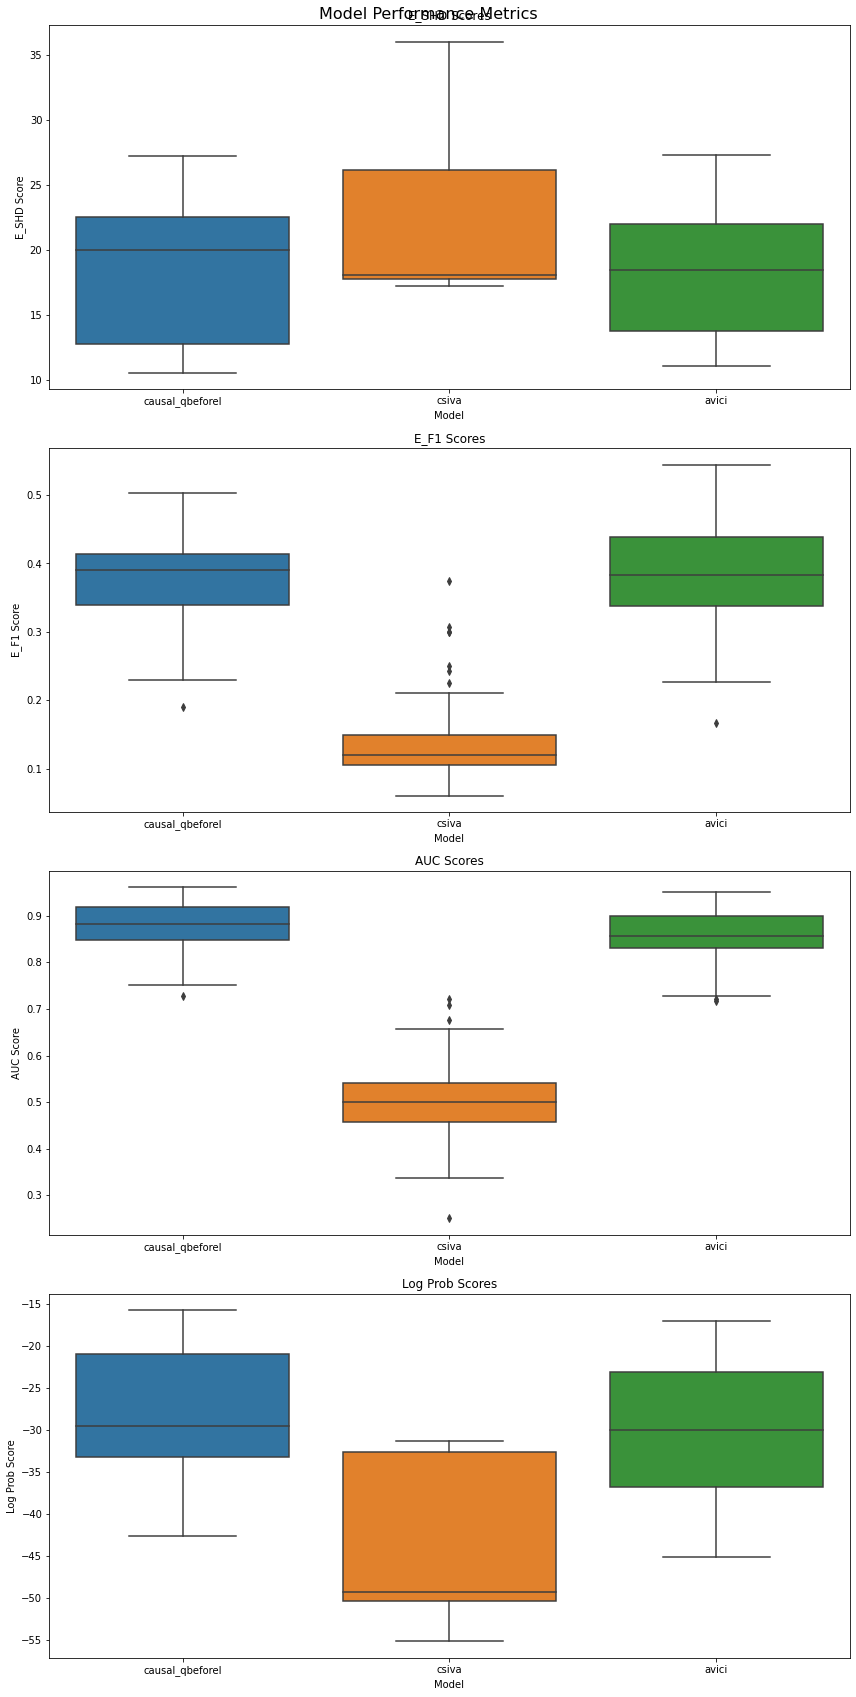

In [5]:
create_plots(
    results
)

In [5]:
import torch as th
from ml2_meta_causal_discovery.utils.datautils import MultipleFileDataset
from pathlib import Path
from ml2_meta_causal_discovery.models.causaltransformernp import (
    AviciDecoder,
    CsivaDecoder,
    CausalProbabilisticDecoder,
)
from ml2_meta_causal_discovery.utils.metrics import (
    expected_shd,
    expected_f1_score,
)
import numpy as np
from ml2_meta_causal_discovery.utils.metrics import cyclicity


model_folder = Path(
    "/vol/bitbucket/ad6013/Research/CausalStructureNeuralProcess/ml2_meta_causal_discovery/experiments/causal_classification/models"
)
MODELS = {
    "avici": AviciDecoder,
    "csiva": CsivaDecoder,
    "causal": CausalProbabilisticDecoder,

}
# Define the path to the test file
test_file = Path(
    "/vol/bitbucket/ad6013/Research/CausalStructureNeuralProcess/ml2_meta_causal_discovery/datasets/data/synth_training_data/linear_gaussian/test_data.hdf5"
)
# Load the models
test_dataset = MultipleFileDataset(
        [test_file],
    )

# Train all the models
TNPD_KWARGS = dict(
    d_model=256,
    emb_depth=1,
    dim_feedforward=512,
    nhead=8,
    dropout=0.0,
    num_layers_encoder=4,
    num_layers_decoder=4,
    device="cuda" if th.cuda.is_available() else "cpu",
    dtype=th.float32,
    num_nodes=10,
    n_perm_samples=25,
    sinkhorn_iter=1000,
    use_positional_encoding=False,
)


all_shd_dict = {}
all_f1_dict = {}
all_samples = {}
total_acyclic = {model:0 for model in MODELS.keys()}
for model_name, model_class in MODELS.items():
    model = model_class(**TNPD_KWARGS)
    model.load_state_dict(th.load(model_folder / f"linear_gaussian_{model_name}" / "model_0.pt"))
    model.eval()
    model.to(TNPD_KWARGS['device'])
    with th.no_grad():
        all_f1_scores = []
        all_shd_scores = []
        for i in range(len(test_dataset)):
            # Create normalised 2var data
            # x = th.randn(1, 1000, 1)
            # y = x @ th.randn(1, 1) + th.randn(1, 1000, 1) * 0.1
            # z = th.randn(1, 1000, 1)
            # full_data = th.cat([x, y, z], dim=-1)
            # norm_full_data = (full_data - full_data.mean(dim=1, keepdim=True)) / full_data.std(dim=1, keepdim=True)
            # label = th.tensor([[0, 1, 0], [0, 0, 0], [0, 0, 0]]).to(th.float32)[None]
            # x = norm_full_data.to(TNPD_KWARGS['device'], th.float32)
            # label = label.to(th.float32)

            data = test_dataset[i]
            x, label = th.from_numpy(data[0]).to(TNPD_KWARGS['device']), th.from_numpy(data[1])
            x = x.to(th.float32)
            label = label.to(th.float32)
            x = x[None]
            label = label[None]
            pred = model.sample(x, num_samples=500)
            pred_analyse = pred.detach().cpu()
            # Count unmber of acyclic graphs
            num_acyclic = sum([cyclicity(sample[0]) > 0 for sample in pred_analyse.detach().cpu()])
            total_acyclic[model_name] += num_acyclic
            # Calculate SHD
            shd = expected_shd(label.numpy(), pred_analyse.numpy())
            all_shd_scores.append(shd)
            # Calculate F1
            f1_score = expected_f1_score(label, pred_analyse)
            all_f1_scores.append(f1_score)
        all_shd_dict[model_name] = all_shd_scores
        all_f1_dict[model_name] = all_f1_scores

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` 

In [6]:
total_acyclic

{'avici': tensor(6943), 'csiva': tensor(9100), 'causal': tensor(0)}

In [24]:
all_f1_dict = {model: [score for score in scores if score != 0] for model, scores in all_f1_dict.items()}

In [7]:
def plot_boxplot(data_dict):
    """
    Creates a box plot for the values in a dictionary where the values are arrays.

    :param data_dict: Dictionary where values are arrays or lists of arrays
    """
    # Convert dictionary values (arrays) to a list of numeric values for each key
    data_values = {key: [item[0] if isinstance(item, np.ndarray) else item for item in values] for key, values in data_dict.items()}

    # Create boxplot
    plt.boxplot(data_values.values())

    # Set x-ticks to the dictionary keys
    plt.xticks(range(1, len(data_dict.keys()) + 1), data_dict.keys())

    # Add titles and labels
    plt.title('Box Plot for Dictionary Data')
    plt.ylabel('Values')

    # Show plot
    plt.show()




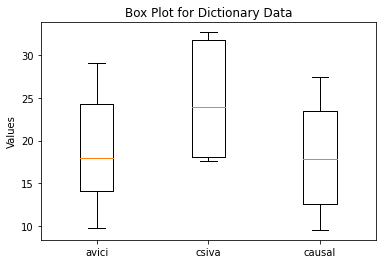

In [8]:
plot_boxplot(all_shd_dict)

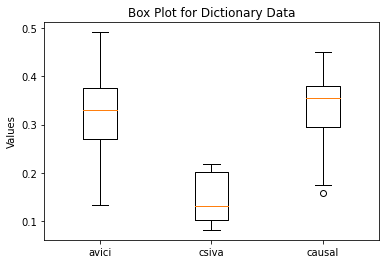

In [9]:
plot_boxplot(all_f1_dict)

In [12]:
label.shape

torch.Size([1, 3, 3])

In [13]:
all_f1_dict

{'csiva': 0.29607000000000006,
 'causal': 0.23076666666666665,
 'avici': 0.150195}

In [2]:
all_f1_dict

{'csiva': 0.8187866666666668,
 'causal': 0.7690533333333335,
 'avici': 0.7694223809523809}

In [2]:
all_f1_dict

{'csiva': 0.29141999999999996,
 'causal': 0.7429300000000001,
 'avici': 0.7513157142857143}

In [15]:
# Count number of acyclic samples
for model_name, samples in all_samples.items():
    print(f"Model: {model_name}")
    num_selfloop = 0
    num_cyclic = 0
    num_indep = 0
    for sample in samples:
        sample = sample.squeeze(0)
        if sample[0, 0] == 1 or sample[1, 1] == 1 or sample[2, 2] == 1:
            num_selfloop += 1
        elif sample[0, 1] == 1 and sample[1, 0] == 1:
            num_cyclic += 1
        elif sample[0, 1] == 0 and sample[1, 0] == 0:
            num_indep += 1

    print(f"  Self-loop: {num_selfloop}")
    print(f"  Cyclic: {num_cyclic}")
    print(f"  Independent: {num_indep}")

Model: csiva
  Self-loop: 28
  Cyclic: 0
  Independent: 0
Model: causal
  Self-loop: 0
  Cyclic: 0
  Independent: 0
Model: avici
  Self-loop: 58
  Cyclic: 0
  Independent: 24


In [15]:
from ml2_meta_causal_discovery.datasets.causal_graph_generator import (
    generate_synthetic_dag,
)

import numpy as np

dag = generate_synthetic_dag(3, np.random.randint(0, 4), "ER")

In [10]:
samples

array([[[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 1.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
     

In [95]:
import numpy as np

np.random.randint(0, 4)

2

In [24]:
import h5py

data_file = Path(
    "/vol/bitbucket/ad6013/Research/CausalStructureNeuralProcess/ml2_meta_causal_discovery/datasets/data/synth_training_data/linear_gaussian/train_data.hdf5"
)

with h5py.File(data_file, "r") as f:
    data = f["data"][:]
    labels = f["label"][:]

In [28]:
# Get bin count of the number of edges
bin_counts = {}
for graph in labels:
    num_edges = np.sum(graph)
    if num_edges not in bin_counts:
        bin_counts[num_edges] = 0
    bin_counts[num_edges] += 1

In [29]:
bin_counts

{1.0: 33593, 3.0: 33312, 2.0: 33095}

In [34]:
labels[3]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])